# # Brain MRI model to predict brain tumor with reason

In [ ]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
import random, os

In [ ]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Dataset
train_dir = "/content/drive/MyDrive/MRI Images/Training"
test_dir  = "/content/drive/MyDrive/MRI Images/Testing"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [ ]:
# Data Generators
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

N_CLASSES = len(train_generator.class_indices)
print("Classes:", train_generator.class_indices)

Found 5712 images belonging to 4 classes.
Found 1321 images belonging to 4 classes.
Classes: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [ ]:
# Build Model
base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224,224,3))
base.trainable = False  # freeze base model

x = layers.GlobalAveragePooling2D()(base.output)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.3)(x)
out = layers.Dense(N_CLASSES, activation="softmax")(x)

model = models.Model(inputs=base.input, outputs=out)

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,378,535 (16.70 MB)

 Trainable params: 328,964 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
# Callbacks
es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
rlr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, verbose=1)

In [ ]:
# Train Model
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=20,
    callbacks=[es, rlr]
)

Epoch 1/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 1454s 8s/step - accuracy: 0.8350 - loss: 0.4238 - val_accuracy: 0.8584 - val_loss: 0.3485 - learning_rate: 0.0010
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 96s 535ms/step - accuracy: 0.8826 - loss: 0.3104 - val_accuracy: 0.8645 - val_loss: 0.3140 - learning_rate: 0.0010
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 97s 543ms/step - accuracy: 0.8901 - loss: 0.2790 - val_accuracy: 0.8910 - val_loss: 0.2568 - learning_rate: 0.0010
Epoch 4/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 94s 525ms/step - accuracy: 0.9114 - loss: 0.2396 - val_accuracy: 0.8963 - val_loss: 0.2420 - learning_rate: 0.0010
Epoch 5/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 140s 516ms/step - accuracy: 0.9124 - loss: 0.2258 - val_accuracy: 0.9114 - val_loss: 0.2237 - learning_rate: 0.0010
Epoch 6/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 95s 530ms/step - accuracy: 0.9235 - loss: 0.2010 - val_accuracy: 0.9008 - val_loss: 0.2471 - learning_rate: 0.0010
Epoch 7/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 92s 515ms/step - accuracy: 0.9

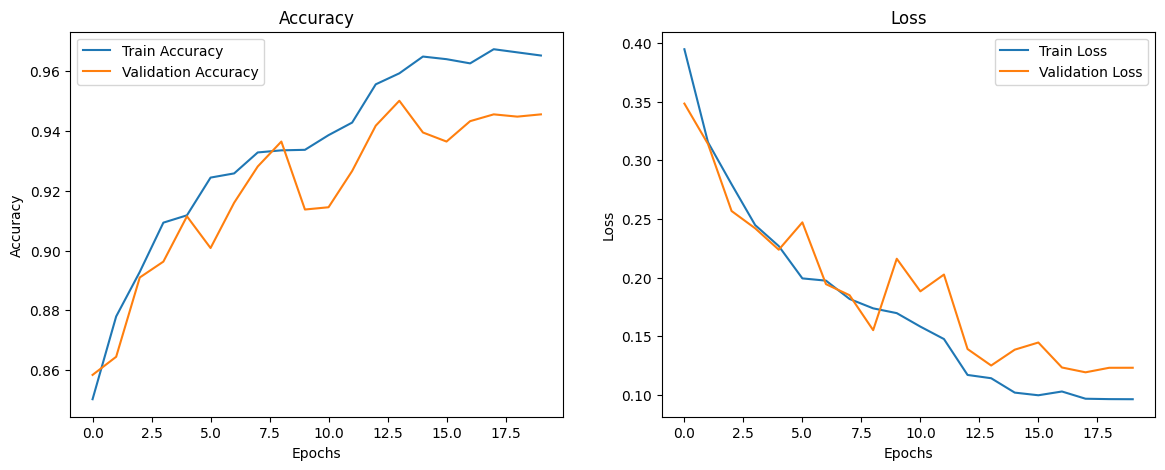

In [10]:
# Plot Training History
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.legend(); plt.title("Accuracy"); plt.xlabel("Epochs"); plt.ylabel("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.legend(); plt.title("Loss"); plt.xlabel("Epochs"); plt.ylabel("Loss")

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━

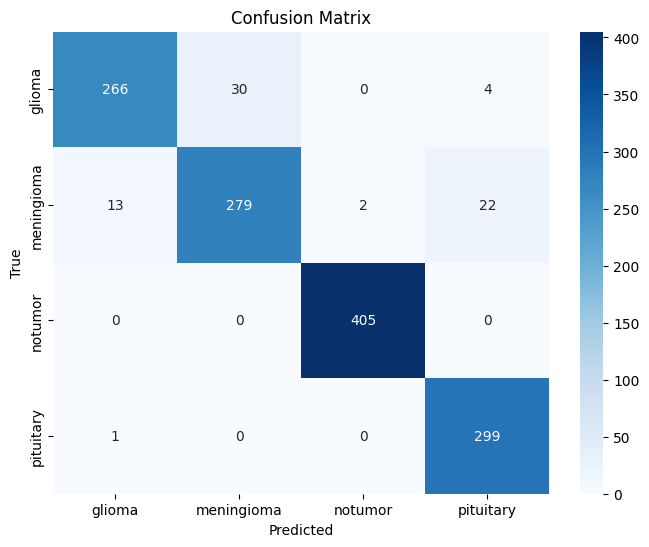


Classification Report:

              precision    recall  f1-score   support

      glioma       0.95      0.89      0.92       300
  meningioma       0.90      0.88      0.89       316
     notumor       1.00      1.00      1.00       405
   pituitary       0.92      1.00      0.96       300

    accuracy                           0.95      1321
   macro avg       0.94      0.94      0.94      1321
weighted avg       0.95      0.95      0.94      1321



In [11]:
# Evaluation
y_true = []
y_pred = []

for images, labels in test_generator:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))
    if len(y_true) >= test_generator.samples:
        break

cm = confusion_matrix(y_true, y_pred)
class_labels = list(test_generator.class_indices.keys())

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

In [12]:
# Grad-CAM Functions
def get_img_array(img_path, size=(224, 224)):
    img = tf.keras.utils.load_img(img_path, target_size=size)
    arr = tf.keras.utils.img_to_array(img)
    arr = np.expand_dims(arr, axis=0)
    return preprocess_input(arr)

def make_gradcam_heatmap(img_array, model, last_conv_layer_name="top_conv", pred_index=None):
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]

    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

def display_prediction(img_path, model, last_conv_layer_name="top_conv", alpha=0.4):
    img_array = get_img_array(img_path)
    preds = model.predict(img_array)
    pred_class = np.argmax(preds[0])
    confidence = preds[0][pred_class]
    labels = list(train_generator.class_indices.keys())

    # Print prediction and probabilities
    print(f"\nPredicted class: {labels[pred_class]}")
    print(f"Confidence Score: {confidence:.2f}")
    print("Class Probabilities:")
    for i, label in enumerate(labels):
        print(f" - {label}: {preds[0][i]:.2f}")

    # Grad-CAM
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    img = tf.keras.utils.load_img(img_path)
    img = tf.keras.utils.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)
    heatmap = np.expand_dims(heatmap, axis=-1)
    heatmap = tf.image.resize(heatmap, (img.shape[0], img.shape[1])).numpy()

    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.imshow(img.astype("uint8"))
    plt.title("Original Image")

    plt.subplot(1,2,2)
    plt.imshow(img.astype("uint8"))
    plt.imshow(heatmap, cmap="jet", alpha=alpha)
    plt.title(f"Grad-CAM: {labels[pred_class]}")
    plt.show()


Testing Image: /content/drive/MyDrive/CDSS/Brain_Classifier_Images/Te-gl_0011.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step

Predicted class: glioma
Confidence Score: 0.76
Class Probabilities:
 - glioma: 0.76
 - meningioma: 0.09
 - notumor: 0.00
 - pituitary: 0.14


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


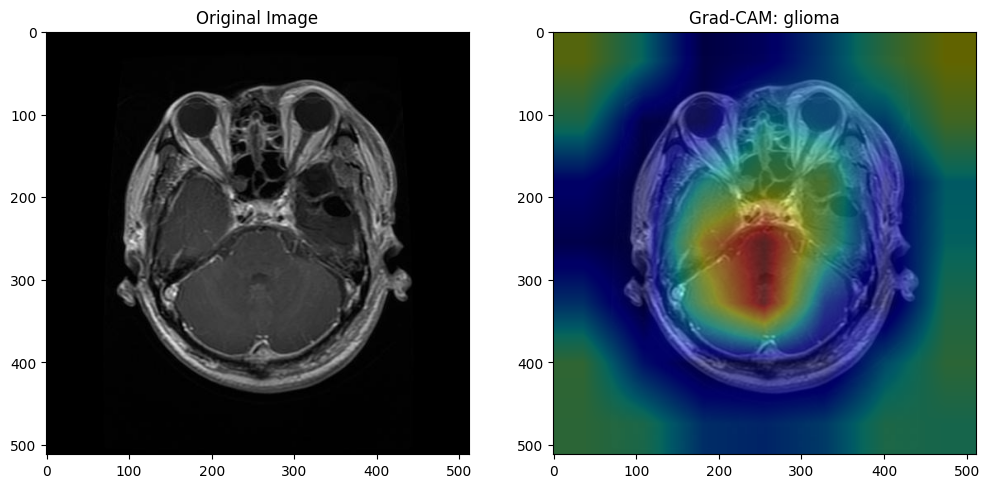

In [13]:
# Test on User-Selected Image
img_path = "/content/drive/MyDrive/CDSS/Brain_Classifier_Images/Te-gl_0011.jpg"

print(f"\nTesting Image: {img_path}")
display_prediction(img_path, model)

In [15]:
# Save Model & Labels for Webapp
np.save("brain_labels.npy", class_labels)
model.save("brain_tumor_model.h5")
print("✅ Model and class labels saved successfully!")

✅ Model and class labels saved successfully!
